<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/First_test_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install accelerate -U --quiet
!pip install datasets --quiet
!pip install evaluate --quiet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
import torch
from typing import Dict
import torch
from datasets import load_dataset
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, Trainer, TrainingArguments, set_seed, DataCollatorWithPadding
import evaluate
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random as rand
from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv
Saving dev_df_complete.json to dev_df_complete.json
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install datasets --quiet

from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
# login(token="")

# dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

# dev_df = dataset['validation'].to_pandas()

In [2]:
#Wikipedia text (1000 characters) for each item
#df_train_text = pd.read_json('/content/train_with_text.json', lines=True)[['item','text']]
#df_dev_text = pd.read_json('/content/dev_with_text.json', lines=True)[['item','text']]
dev_df = pd.read_json('dev_df_complete.json',lines=True, orient='record')

#500 first characters
#df_train_text['text'] = df_train_text['text'].apply(lambda x: x[:500])
#df_dev_text['text'] = df_dev_text['text'].apply(lambda x: x[:500])

# Cleaning the tables

In [3]:
# Select the labels and associated labels to correct
to_correct = train_df[train_df["label"].isin(['cultural agn','cultural represent', 'cultural ex', 'cultural ag'])][['item', 'label']]

# Create the mapping for correction
mapping_correction = {
  'cultural agn' : 'cultural agnostic',
  'cultural represent' : 'cultural representative',
  'cultural ex' : 'cultural exclusive',
  'cultural ag' : 'cultural agnostic'
}

# Apply the correction
to_correct['label'] = to_correct['label'].map(mapping_correction)

# We update the transformations to the initial dataset
train_df.set_index('item', inplace=True)
to_correct.set_index('item', inplace=True)

train_df.update(to_correct)
train_df.reset_index(inplace=True)

# Select the items that have no label, or with label 'cultural', or 'cult'
to_classify = train_df[(train_df["label"].isin(["cultural", "cult"])) | (train_df["label"].isna())][['item', 'name', 'description']]

# Create the dictionnary for the mapping
categories = {
    'http://www.wikidata.org/entity/Q957033': 'cultural representative',
    'http://www.wikidata.org/entity/Q30327019': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q811361': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q12014207': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q257907': 'cultural exclusive',
    'http://www.wikidata.org/entity/Q1136336': 'cultural representative',
    'http://www.wikidata.org/entity/Q67111': 'cultural representative',
    'http://www.wikidata.org/entity/Q1089672': 'cultural representative',
    'http://www.wikidata.org/entity/Q85755629': 'cultural representative',
    'http://www.wikidata.org/entity/Q206912': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q23228': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q3196604': 'cultural representative',
    'http://www.wikidata.org/entity/Q1940624': 'cultural representative'
}

# Apply the classification
to_classify['label'] = to_classify['item'].map(categories)

# We update the transformations to the initial dataset
train_df.set_index('item', inplace=True)
to_classify.set_index('item', inplace=True)

train_df.update(to_classify)
train_df.reset_index(inplace=True)

dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}

train_df['label'] = train_df['label'].map(dict_mapping)
train_df['label'] = train_df['label'].apply(lambda x: np.array(x))

dev_df['label'] = dev_df['label'].map(dict_mapping)
dev_df['label'] = dev_df['label'].apply(lambda x: np.array(x))

In [4]:
train_df["idx"] = range(len(train_df))
dev_df["idx"] = range(len(dev_df))

# Creation of the dictionnary datasets
train_dict = train_df[['idx','name','description','label']].to_dict(orient="list")
train_dataset = Dataset.from_dict(train_dict)

dev_dict = dev_df[['idx','name','description','label']].to_dict(orient="list")
dev_dataset = Dataset.from_dict(dev_dict)

# Merge the datasets into one single dictionnary
datasets = DatasetDict({
    "train": train_dataset,
    "dev": dev_dataset
})

# Visualisation
datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'name', 'description', 'label'],
        num_rows: 6251
    })
    dev: Dataset({
        features: ['idx', 'name', 'description', 'label'],
        num_rows: 300
    })
})

# Metrics

In [5]:
def compute_metrics(eval_pred):

    # Load metrics
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Computation
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted", zero_division=0)
    cm = confusion_matrix(labels, predictions)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cm": cm
    }

# Models

## Model 1 : DistilBERT

We will rely on the Huggingface **AutoModelForSequenceClassification** class from huggingface repository. This is a wrapper for encoder-only models, that allow us to simply create a model suitable to solve a classification task over textual sentences.

**BERT Encoding**

We use a BERT-style pretrained encoder model, in this setting, we rely on the tokenization practices of those models.

Each sentence is:
- Splitted in tokens
- Added special tokens (\[CLS\], \[SEP\])
- Sum Position Embeddings
- Sum Segment Embeddings (Deprecated)

![alt text](https://miro.medium.com/v2/resize:fit:998/1*EKzyGf_l0e57XN491_YAyg.png)

**Sentence Classification**

 In the setting of sentence level classification we will cling to the  standard approach and  apply a MLP over the [CLS] token's embedding of the last encoder layer. This is because the [CLS] token contains a lot of information about the **semantic and syntactitc** structure of the input sentence.

![alt text](https://jalammar.github.io/images/bert-classifier.png "Sentence Classification")

In [6]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Arguments

# We will try with the batch_size of 8
batch_size = 8

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

### Model 1.1
Here, as an input to the distill-BERT model we will feed the  tokenized wikipedia descriptions of the entities.

In [ ]:
## Initialize the model
model_11 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# the tokenization, in case of model 1.1 we will use only the tokenized description of the entity as an input to the classifier
def tokenize_function(examples):
    return tokenizer(examples["description"], padding=True, truncation=True)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model we will rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).


In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs",         # use it later to get the training curves
    load_best_model_at_end=True,                    # ensuring the best model is retrieved
    metric_for_best_model="f1"                      # evaluation metric for the best model retrieval
    )

In [ ]:
# the Trainer definition
trainer = Trainer(
   model=model_11,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,0.773800


TrainOutput(global_step=782, training_loss=0.7203672365154452, metrics={'train_runtime': 48.381, 'train_samples_per_second': 129.204, 'train_steps_per_second': 16.163, 'total_flos': 101318668783200.0, 'train_loss': 0.7203672365154452, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.7291969656944275,
 'eval_accuracy': 0.7,
 'eval_f1': 0.695826544382247,
 'eval_precision': 0.6999913119148876,
 'eval_recall': 0.7,
 'eval_cm': array([[ 47,  24,   5],
        [ 34,  57,  16],
        [  7,   4, 106]]),
 'eval_runtime': 3.7932,
 'eval_samples_per_second': 79.09,
 'eval_steps_per_second': 10.018,
 'epoch': 1.0}

#### Inference
Here we will evaluate  the Trainer on the dev set and also conduct several inferences to be able to qualitatively assess the performance .

In [18]:
# function used to predict all dev set to evaluate the accuracy
def evaluate_trainer(trainer, dataset):
    model_predictions = trainer.predict(dataset)
    logits = model_predictions.predictions
    labels = np.argmax(logits,axis=1)
    return labels


In [ ]:
# function to predict the label
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
# Models input for 10 randomly choosen entities a
inference_examples = [element for element in dev_df["description"]]
inference_examples = rand.sample(inference_examples, 10)
inference_examples

['outdoor controlled environment for experimental purposes',
 'shoe cut from a single piece of leather and secured with a lace, worn in Ancient Rome and later throughout Central Europe',
 'profession',
 'gesture',
 'monarchical title based on claim to be a successor of Muhammad',
 'mountain on a celestial body',
 'Comic artist',
 'Football competition',
 'Italian bitter apéritif made of gentian, rhubarb, and cinchona',
 'literary honour awarded to authors of outstanding literary works in India']

In [ ]:
# The models prediction for these inputs
for element in inference_examples:
  print(f'the model input: {element}')
  print(f'the model prediction: {predict_culture(element, model_11, tokenizer, "cuda:0")}')
  print('\n')

the model input: outdoor controlled environment for experimental purposes
the model prediction: cultural agnostic


the model input: shoe cut from a single piece of leather and secured with a lace, worn in Ancient Rome and later throughout Central Europe
the model prediction: cultural representative


the model input: profession
the model prediction: cultural agnostic


the model input: gesture
the model prediction: cultural exclusive


the model input: monarchical title based on claim to be a successor of Muhammad
the model prediction: cultural exclusive


the model input: mountain on a celestial body
the model prediction: cultural agnostic


the model input: Comic artist
the model prediction: cultural representative


the model input: Football competition
the model prediction: cultural agnostic


the model input: Italian bitter apéritif made of gentian, rhubarb, and cinchona
the model prediction: cultural representative


the model input: literary honour awarded to authors of outstan

#### Evaluation
Here we quantitatively evaluate the accuarcy on the dev set

In [ ]:
dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])
dev_df['predict_label_transformer']

,predict_label_transformer
0,0
1,0
2,1
3,1
4,1
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.7
Precision (weighted): 0.6999913119148876
Recall (weighted): 0.7
F1-score (weighted): 0.695826544382247

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.53      0.62      0.57        76
representative       0.67      0.53      0.59       107
      agnostic       0.83      0.91      0.87       117

      accuracy                           0.70       300
     macro avg       0.68      0.69      0.68       300
  weighted avg       0.70      0.70      0.70       300



<Figure size 600x600 with 0 Axes>

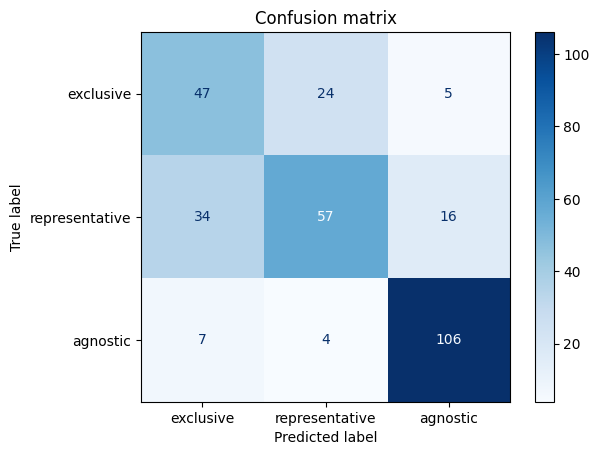

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

### Model 1.2

We modify the input :

Instead of having the description as input, we use "name:description" for each item to give more information to the transformer

In [ ]:
## Initialize the model
model_12 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    text_inputs = [f"{name}: {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(text_inputs, padding=True, truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training





In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs",         # use it later to get the training curves
    load_best_model_at_end=True,
    metric_for_best_model="f1"
    )

In [ ]:
trainer = Trainer(
   model=model_12,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,0.716200


TrainOutput(global_step=782, training_loss=0.6652124507347946, metrics={'train_runtime': 53.9457, 'train_samples_per_second': 115.876, 'train_steps_per_second': 14.496, 'total_flos': 108512397758808.0, 'train_loss': 0.6652124507347946, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6008146405220032,
 'eval_accuracy': 0.77,
 'eval_f1': 0.7662071458596049,
 'eval_precision': 0.7662255383399657,
 'eval_recall': 0.77,
 'eval_cm': array([[ 51,  23,   2],
        [ 26,  68,  13],
        [  3,   2, 112]]),
 'eval_runtime': 1.4281,
 'eval_samples_per_second': 210.065,
 'eval_steps_per_second': 26.608,
 'epoch': 1.0}

#### Inference

Here we will evaluate  the Trainer on the dev set and also conduct several inferences to be able to qualitatively assess the performance .

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
inference_examples = [f"{name}:{desc}" for name, desc in zip(dev_df["name"], dev_df["description"])]
inference_examples = rand.sample(inference_examples, 10)
inference_examples

['Pinewood Toronto Studios:filming location',
 'fungi:biological kingdom, separate from plants and animals',
 'restaurant:single establishment which prepares and serves food, located in building',
 'Karl Landsteiner:Jewish-Austrian biologist, physician and Nobel Prize laureate',
 'A Gang Story:2011 film by Olivier Marchal',
 'dance:rhythmic movement of the body',
 'Pixar:American computer animation studio',
 'Michelangelo:Italian artist and architect (1475–1564)',
 'curia:group of officials who assist in the governance of a particular Church, in Roman Catholicism',
 'Franz Ziehl:German microbiologist (1857–1926)']

In [ ]:
for element in inference_examples:
  print(f'the model input: {element}')
  print(f'the model prediction: {predict_culture(element, model_12, tokenizer, "cuda:0")}')
  print('\n')

the model input: Pinewood Toronto Studios:filming location
the model prediction: cultural representative


the model input: fungi:biological kingdom, separate from plants and animals
the model prediction: cultural agnostic


the model input: restaurant:single establishment which prepares and serves food, located in building
the model prediction: cultural agnostic


the model input: Karl Landsteiner:Jewish-Austrian biologist, physician and Nobel Prize laureate
the model prediction: cultural exclusive


the model input: A Gang Story:2011 film by Olivier Marchal
the model prediction: cultural representative


the model input: dance:rhythmic movement of the body
the model prediction: cultural agnostic


the model input: Pixar:American computer animation studio
the model prediction: cultural representative


the model input: Michelangelo:Italian artist and architect (1475–1564)
the model prediction: cultural representative


the model input: curia:group of officials who assist in the govern

#### Evaluation
the quantitative evaluation onthe dev set

In [ ]:
# Apply the model on the dev set

dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])
dev_df['predict_label_transformer']

,predict_label_transformer
0,0
1,0
2,1
3,1
4,1
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.77
Precision (weighted): 0.7662255383399657
Recall (weighted): 0.77
F1-score (weighted): 0.7662071458596049

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.64      0.67      0.65        76
representative       0.73      0.64      0.68       107
      agnostic       0.88      0.96      0.92       117

      accuracy                           0.77       300
     macro avg       0.75      0.75      0.75       300
  weighted avg       0.77      0.77      0.77       300



<Figure size 600x600 with 0 Axes>

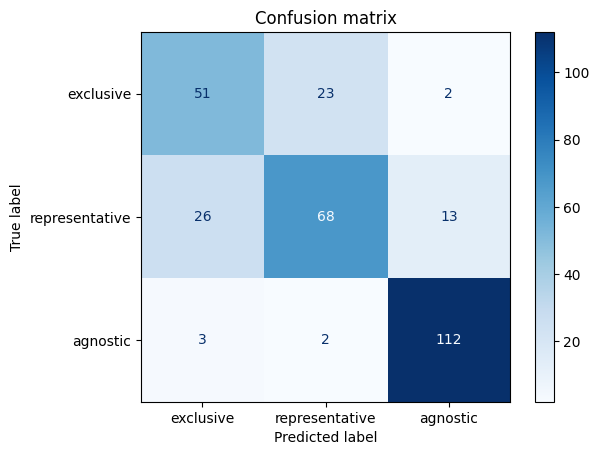

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusions

incorporation of the name was advantageous as it has increased the accuracy by several percent point with respect to the previous  best result

### Model 1.3

No, we try to convey to the model the message that the first element is the name of the entity and the second element is the description of the entity
- Name = Meutre à la tronconeuse
- Descrition = French Horror Moovie

The input becomes : The name of the entity:Meutre à la tronconeuse. The description of the entity: French Horror Moovie

In [7]:
## Initialize the model
model_13 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"the name of the entity:{name}. The description of the entity:{desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [9]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs", # use it later to get the training curves
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [10]:
trainer = Trainer(
   model=model_13,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [11]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,0.724400


TrainOutput(global_step=782, training_loss=0.67312965490629, metrics={'train_runtime': 61.5391, 'train_samples_per_second': 101.578, 'train_steps_per_second': 12.707, 'total_flos': 127920252668832.0, 'train_loss': 0.67312965490629, 'epoch': 1.0})

In [12]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.7070682048797607,
 'eval_accuracy': 0.7333333333333333,
 'eval_f1': 0.729225691443135,
 'eval_precision': 0.7322304324028461,
 'eval_recall': 0.7333333333333333,
 'eval_cm': array([[ 49,  25,   2],
        [ 34,  60,  13],
        [  4,   2, 111]]),
 'eval_runtime': 2.2805,
 'eval_samples_per_second': 131.551,
 'eval_steps_per_second': 16.663,
 'epoch': 1.0}

#### Inference
We do the sanity check, assesing qualitatively the performnce of the given model on several examples randomly choose form the dev set

In [13]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [14]:
inference_examples = [f"the name of the entity:{name}. The description of the entity:{desc}" for name, desc in zip(dev_df["name"], dev_df["description"])]
inference_examples = rand.sample(inference_examples, 10)
inference_examples

['the name of the entity:Château Borély. The description of the entity:museum',
 'the name of the entity:Alcantara. The description of the entity:trademark of a synthetic fabric',
 'the name of the entity:Joe Kubert. The description of the entity:Polish-born American comic book artist (1926-2012)',
 'the name of the entity:Hessischer Rundfunk. The description of the entity:German public broadcaster',
 'the name of the entity:gauze. The description of the entity:thin translucent fabric with a open weave',
 "the name of the entity:courtship. The description of the entity:ritual, period in a couple's relationship which precedes their engagement and marriage",
 'the name of the entity:carbatina. The description of the entity:shoe cut from a single piece of leather and secured with a lace, worn in Ancient Rome and later throughout Central Europe',
 'the name of the entity:trade magazine. The description of the entity:periodical dedicated to a particular field',
 'the name of the entity:bloc

In [15]:
for element in inference_examples:
  print(f'the model input: {element}')
  print(f'the model prediction: {predict_culture(element, model_13, tokenizer, "cuda:0")}')
  print('\n')

the model input: the name of the entity:Château Borély. The description of the entity:museum
the model prediction: cultural exclusive


the model input: the name of the entity:Alcantara. The description of the entity:trademark of a synthetic fabric
the model prediction: cultural agnostic


the model input: the name of the entity:Joe Kubert. The description of the entity:Polish-born American comic book artist (1926-2012)
the model prediction: cultural representative


the model input: the name of the entity:Hessischer Rundfunk. The description of the entity:German public broadcaster
the model prediction: cultural exclusive


the model input: the name of the entity:gauze. The description of the entity:thin translucent fabric with a open weave
the model prediction: cultural agnostic


the model input: the name of the entity:courtship. The description of the entity:ritual, period in a couple's relationship which precedes their engagement and marriage
the model prediction: cultural agnostic

#### Evaluation

In [19]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])
# Visualisation
dev_df['predict_label_transformer']

,predict_label_transformer
0,0
1,0
2,1
3,1
4,1
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.7333333333333333
Precision (weighted): 0.7322304324028461
Recall (weighted): 0.7333333333333333
F1-score (weighted): 0.729225691443135

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.56      0.64      0.60        76
representative       0.69      0.56      0.62       107
      agnostic       0.88      0.95      0.91       117

      accuracy                           0.73       300
     macro avg       0.71      0.72      0.71       300
  weighted avg       0.73      0.73      0.73       300



<Figure size 600x600 with 0 Axes>

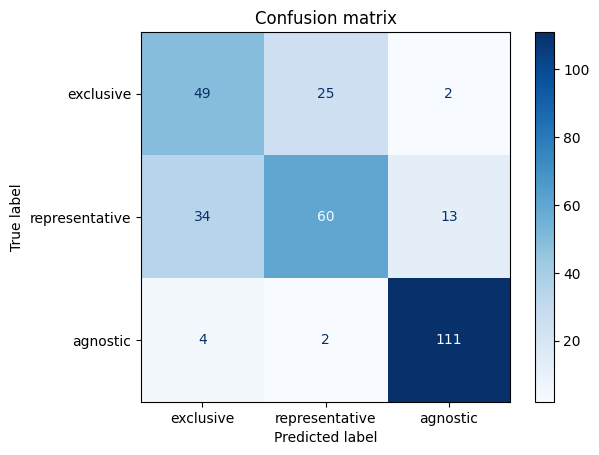

In [20]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusions

The accuracy has slightly decreased, 3 per cent point, with respect to the model with the model fed with NAME:DESCRIPTION

### Model 1.4


Here we would like to enrich the transformer input by feeding it with the  text that we have scraped from the wikipedia page of the entity. We will , limit ourselves to first 1000 words THOUGH , to ensure relatively smooth performance. we will also utylize the name and the short description that proved to work veyr well earlier

In [ ]:
#adding text columns
train_df = pd.merge(train_df, df_train_text, on='item', how='left')
dev_df = pd.merge(dev_df, df_dev_text, on='item', how='left')

train_df["idx"] = range(len(train_df))
dev_df["idx"] = range(len(dev_df))

# Creation of the dictionnary datasets
train_dict = train_df[['idx','name','text','label','description']].to_dict(orient="list")
train_dataset = Dataset.from_dict(train_dict)

dev_dict = dev_df[['idx','name','text','label','description']].to_dict(orient="list")
dev_dataset = Dataset.from_dict(dev_dict)

# Merge the datasets into one single dictionnary
datasets = DatasetDict({
    "train": train_dataset,
    "dev": dev_dataset
})

# Visualisation
datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'name', 'text', 'label', 'description'],
        num_rows: 6251
    })
    dev: Dataset({
        features: ['idx', 'name', 'text', 'label', 'description'],
        num_rows: 300
    })
})

In [ ]:
## Initialize the model
model_14 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f'{name}:{desc}:{text}' for name,desc,text in zip(examples["name"], examples["description"],examples["text"])]
    return tokenizer(inputs, padding=True, truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
datasets['train']

Dataset({
    features: ['idx', 'name', 'text', 'label', 'description'],
    num_rows: 6251
})

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs",         # use it later to get the training curves
    load_best_model_at_end=True,
    metric_for_best_model="f1"
    )

In [ ]:
trainer = Trainer(
   model=model_14,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,0.700800


TrainOutput(global_step=782, training_loss=0.6536420153839814, metrics={'train_runtime': 230.6201, 'train_samples_per_second': 27.105, 'train_steps_per_second': 3.391, 'total_flos': 636871661823060.0, 'train_loss': 0.6536420153839814, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.66971355676651,
 'eval_accuracy': 0.76,
 'eval_f1': 0.7569354116406396,
 'eval_precision': 0.7561764416315049,
 'eval_recall': 0.76,
 'eval_cm': array([[ 50,  25,   1],
        [ 25,  68,  14],
        [  4,   3, 110]]),
 'eval_runtime': 3.9563,
 'eval_samples_per_second': 75.828,
 'eval_steps_per_second': 9.605,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])
# Visualisation
dev_df['predict_label_transformer']

,predict_label_transformer
0,0
1,1
2,1
3,1
4,1
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.76
Precision (weighted): 0.7561764416315049
Recall (weighted): 0.76
F1-score (weighted): 0.7569354116406396

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.63      0.66      0.65        76
representative       0.71      0.64      0.67       107
      agnostic       0.88      0.94      0.91       117

      accuracy                           0.76       300
     macro avg       0.74      0.74      0.74       300
  weighted avg       0.76      0.76      0.76       300



<Figure size 600x600 with 0 Axes>

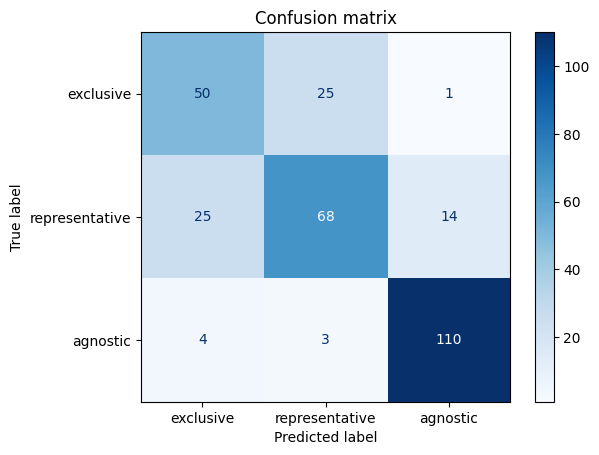

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusions

The performance was very similar than without the wikipedia scraped  text

## Model 2 : DeBERTa

In [ ]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "microsoft/deberta-v3-small"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 8

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [ ]:
## Initialize the model
model_21 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs",         # use it later to get the training curves
    load_best_model_at_end=True,
    metric_for_best_model="f1"
    )

In [ ]:
trainer = Trainer(
   model=model_21,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,1.027800


TrainOutput(global_step=782, training_loss=0.9598048568686561, metrics={'train_runtime': 309.1531, 'train_samples_per_second': 20.22, 'train_steps_per_second': 2.529, 'total_flos': 589194996227586.0, 'train_loss': 0.9598048568686561, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.8048135638237,
 'eval_accuracy': 0.57,
 'eval_f1': 0.4820355584738584,
 'eval_precision': 0.5307541432344921,
 'eval_recall': 0.57,
 'eval_cm': array([[ 67,   2,   7],
        [ 84,   3,  20],
        [ 12,   4, 101]]),
 'eval_runtime': 7.4497,
 'eval_samples_per_second': 40.27,
 'eval_steps_per_second': 5.101,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("President of Paraguay", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("River", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Caponata", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Bread", model_21, tokenizer, "cuda:0")

'cultural agnostic'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])

# Transform the labels into integers
dev_df['predict_label_transformer']
# Visualisation


,predict_label_transformer
0,0
1,0
2,0
3,0
4,0
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.57
Precision (weighted): 0.5307541432344921
Recall (weighted): 0.57
F1-score (weighted): 0.4820355584738584

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.41      0.88      0.56        76
representative       0.33      0.03      0.05       107
      agnostic       0.79      0.86      0.82       117

      accuracy                           0.57       300
     macro avg       0.51      0.59      0.48       300
  weighted avg       0.53      0.57      0.48       300



<Figure size 600x600 with 0 Axes>

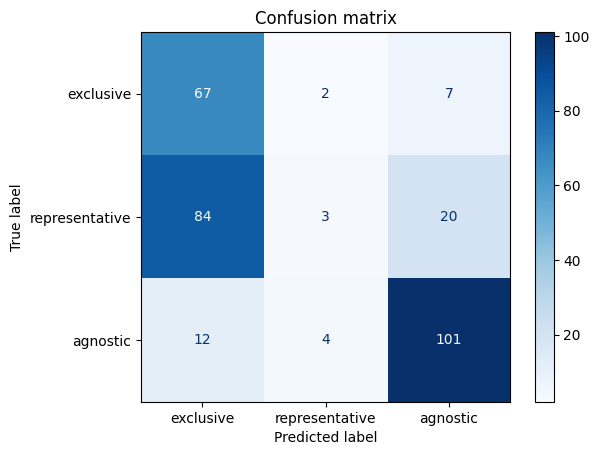

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusion

The accuracy dropped to 57%, and the F1 score to 48%. We won't use this model as a final model

## Model 3 : RoBERTa

In [ ]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "roberta-base"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [ ]:
## Initialize the model
model_31 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

KeyError: 'description'

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_31,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7689237010722257, metrics={'train_runtime': 79.0968, 'train_samples_per_second': 79.03, 'train_steps_per_second': 2.478, 'total_flos': 231124581738288.0, 'train_loss': 0.7689237010722257, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6331952810287476,
 'eval_accuracy': 0.7166666666666667,
 'eval_f1': 0.7162604093813523,
 'eval_precision': 0.7168085587532048,
 'eval_recall': 0.7166666666666667,
 'eval_cm': array([[ 41,  32,   3],
        [ 26,  71,  10],
        [  3,  11, 103]]),
 'eval_runtime': 3.2394,
 'eval_samples_per_second': 92.61,
 'eval_steps_per_second': 11.731,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_31, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_31, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_31, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Caponata", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Bread", model_31, tokenizer, "cuda:0")

'cultural representative'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_31, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,1
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,1


Accuracy: 0.6866666666666666
Precision (weighted): 0.6701554937523816
Recall (weighted): 0.6866666666666666
F1-score (weighted): 0.666291362097034

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.58      0.33      0.42        76
representative       0.62      0.67      0.65       107
      agnostic       0.77      0.93      0.84       117

      accuracy                           0.69       300
     macro avg       0.66      0.64      0.64       300
  weighted avg       0.67      0.69      0.67       300



<Figure size 600x600 with 0 Axes>

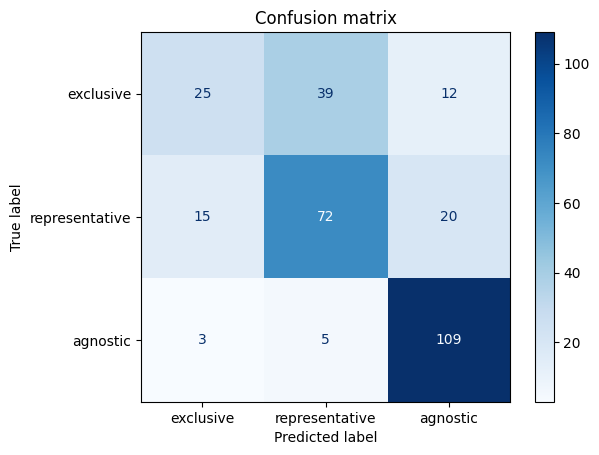

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusion

Better than DeBERTa, but still worst than RoBERTa

## Model 4 : BERT

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

In [ ]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "bert-base-uncased"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [ ]:
## Initialize the model
model_41 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_41,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7665796863789461, metrics={'train_runtime': 74.2414, 'train_samples_per_second': 84.198, 'train_steps_per_second': 2.64, 'total_flos': 218373858846360.0, 'train_loss': 0.7665796863789461, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6599409580230713,
 'eval_accuracy': 0.7233333333333334,
 'eval_f1': 0.7156924068694559,
 'eval_precision': 0.712893023874171,
 'eval_recall': 0.7233333333333334,
 'eval_cm': array([[ 43,  31,   2],
        [ 26,  62,  19],
        [  4,   1, 112]]),
 'eval_runtime': 2.3165,
 'eval_samples_per_second': 129.507,
 'eval_steps_per_second': 16.404,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_41, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_41, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_41, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_41, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_41, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Caponata", model_41, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Bread", model_41, tokenizer, "cuda:0")

'cultural agnostic'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_41, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,label,subclass_depth,subclasses,instances_of,instances_of_up,date,...,category_comics and anime,category_music,category_films,category_biology,category_geography,category_combined,label_int,main_country_cat,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,1,1,0,0,3,1900,...,0,0,0,0,0,0,1,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,0,1,0,0,1,1957,...,0,1,0,0,0,0,0,1,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,1,1,0,0,2,1998,...,1,0,0,0,0,0,1,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,0,1,0,0,1,2011,...,0,0,1,0,0,0,0,1,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,1,1,0,0,1,1900,...,0,0,0,0,0,1,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,2,8,56,1,2,-1,...,0,0,0,0,0,0,2,0,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,1,1,0,0,3,1719,...,0,0,0,0,0,1,1,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,0,9,4,0,1,-1,...,0,0,0,0,0,0,0,1,297,0
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,1,1,0,0,1,1882,...,0,0,0,0,0,0,1,1,298,0


Accuracy: 0.69
Precision (weighted): 0.676708581408272
Recall (weighted): 0.69
F1-score (weighted): 0.6720550055005501

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.62      0.42      0.50        76
representative       0.65      0.58      0.61       107
      agnostic       0.74      0.97      0.84       117

      accuracy                           0.69       300
     macro avg       0.67      0.66      0.65       300
  weighted avg       0.68      0.69      0.67       300



<Figure size 600x600 with 0 Axes>

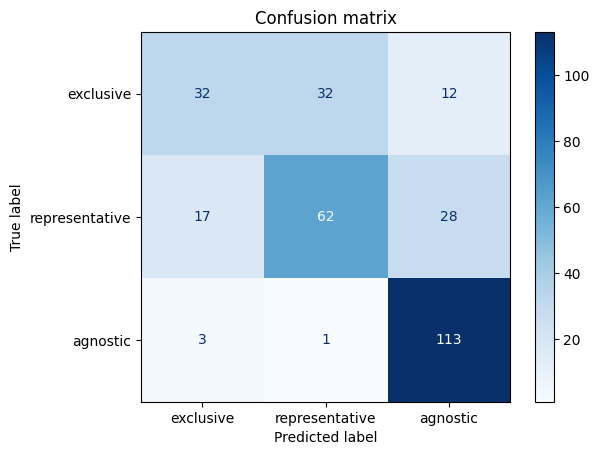

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

#### Conclusion

Not better than DistilBERT

# GPT

In [21]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, set_seed
import torch

### Model Parameters
language_model_name = "gpt2"

### Training Arguments

# We will try with the batch_size of 8
batch_size = 8

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [22]:
## Initialize the model
model_gpt = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes


# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Ensure model knows about the new [PAD] token
model_gpt.resize_token_embeddings(len(tokenizer))

# Set device
model_gpt.to(device)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# the tokenization, in case of model 1.1 we will use only the tokenized description of the entity as an input to the classifier
def tokenize_function(examples):
    return tokenizer(examples["description"], padding=True, truncation=True)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [23]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

#### Training

To train a transformer model we will rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).


In [27]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs",         # use it later to get the training curves
    load_best_model_at_end=True,                    # ensuring the best model is retrieved
    metric_for_best_model="f1"                      # evaluation metric for the best model retrieval
    )

In [31]:
# the Trainer definition
trainer = Trainer(
   model=model_gpt,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

# Set pad_token_id
model_gpt.config.pad_token_id = tokenizer.pad_token_id

In [36]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,1.118800


TrainOutput(global_step=782, training_loss=0.9493909479711976, metrics={'train_runtime': 116.0019, 'train_samples_per_second': 53.887, 'train_steps_per_second': 6.741, 'total_flos': 208861686171648.0, 'train_loss': 0.9493909479711976, 'epoch': 1.0})

In [37]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.7197902202606201,
 'eval_accuracy': 0.6766666666666666,
 'eval_f1': 0.6755292312552179,
 'eval_precision': 0.6881833333333333,
 'eval_recall': 0.6766666666666666,
 'eval_cm': array([[ 48,  23,   5],
        [ 43,  52,  12],
        [  9,   5, 103]]),
 'eval_runtime': 1.8577,
 'eval_samples_per_second': 161.489,
 'eval_steps_per_second': 20.455,
 'epoch': 1.0}

#### Inference
Here we will evaluate  the Trainer on the dev set and also conduct several inferences to be able to qualitatively assess the performance .

In [38]:
# function used to predict all dev set to evaluate the accuracy
def evaluate_trainer(trainer, dataset):
    model_predictions = trainer.predict(dataset)
    logits = model_predictions.predictions
    labels = np.argmax(logits,axis=1)
    return labels

In [39]:
# function to predict the label
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [40]:
# Models input for 10 randomly choosen entities a
inference_examples = [element for element in dev_df["description"]]
inference_examples = rand.sample(inference_examples, 10)
inference_examples

['museum',
 'trademark of a synthetic fabric',
 'Polish-born American comic book artist (1926-2012)',
 'German public broadcaster',
 'thin translucent fabric with a open weave',
 "ritual, period in a couple's relationship which precedes their engagement and marriage",
 'shoe cut from a single piece of leather and secured with a lace, worn in Ancient Rome and later throughout Central Europe',
 'periodical dedicated to a particular field',
 'non-ruling but legal political parties in an authoritarian or totalitarian regime as auxiliary parties and members of a ruling coalition',
 'American computer animation studio']

In [42]:
# The models prediction for these inputs
for element in inference_examples:
  print(f'the model input: {element}')
  print(f'the model prediction: {predict_culture(element, model_gpt, tokenizer, "cuda:0")}')
  print('\n')

the model input: museum
the model prediction: cultural exclusive


the model input: trademark of a synthetic fabric
the model prediction: cultural agnostic


the model input: Polish-born American comic book artist (1926-2012)
the model prediction: cultural representative


the model input: German public broadcaster
the model prediction: cultural exclusive


the model input: thin translucent fabric with a open weave
the model prediction: cultural agnostic


the model input: ritual, period in a couple's relationship which precedes their engagement and marriage
the model prediction: cultural agnostic


the model input: shoe cut from a single piece of leather and secured with a lace, worn in Ancient Rome and later throughout Central Europe
the model prediction: cultural representative


the model input: periodical dedicated to a particular field
the model prediction: cultural agnostic


the model input: non-ruling but legal political parties in an authoritarian or totalitarian regime as au

#### Evaluation
Here we quantitatively evaluate the accuarcy on the dev set

In [43]:
dev_df['predict_label_transformer'] = evaluate_trainer(trainer,tokenized_datasets['dev'])
dev_df['predict_label_transformer']

,predict_label_transformer
0,0
1,0
2,1
3,1
4,1
...,...
295,2
296,0
297,0
298,0


Accuracy: 0.6766666666666666
Precision (weighted): 0.6881833333333333
Recall (weighted): 0.6766666666666666
F1-score (weighted): 0.6755292312552179

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.48      0.63      0.55        76
representative       0.65      0.49      0.56       107
      agnostic       0.86      0.88      0.87       117

      accuracy                           0.68       300
     macro avg       0.66      0.67      0.66       300
  weighted avg       0.69      0.68      0.68       300



<Figure size 600x600 with 0 Axes>

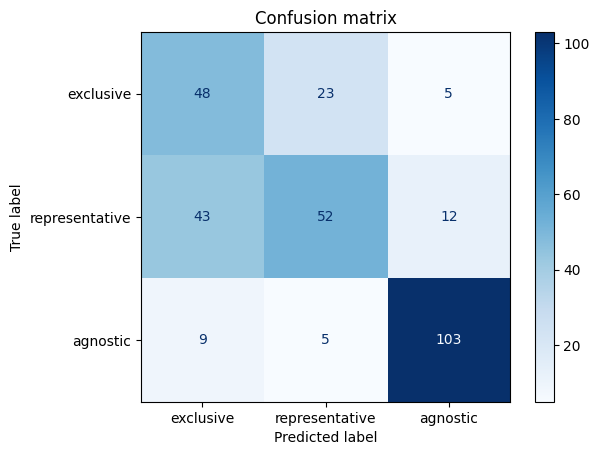

In [44]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

# Exportation